In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.rrule import rrule, MONTHLY

In [2]:
df = pd.read_csv('ncog.csv')

In [3]:
df.head()

,day,month,year,t,d,arm
0,19,6,78,248,1,A
1,15,12,78,160,1,A
2,20,7,78,319,0,A
3,17,11,78,277,1,A
4,15,12,78,440,1,A


In [4]:
df['date_beg'] = df['year'].map(str) + '-' + df['month'].map(str) + '-' + df['day'].map(str)
df['date_beg'] = pd.to_datetime(df['date_beg'])
df['date_beg'] = df['date_beg'].dt.date
df['date_end'] = df.apply(lambda s: s['date_beg'] + timedelta(days=s['t']) ,1)
df['month_abs'] = df.apply(lambda df: len(list(rrule(MONTHLY, dtstart=df['date_beg'], until=df['date_end']))) - 1, 1)

In [5]:
df['month_abs'] = np.floor(df['t'] / 30) + 1
dfB = df[df['arm'] == 'B']
df = df[df['arm'] == 'A']

In [6]:
df.shape

(51, 9)

In [7]:
df = df.sort_values('t')
df['t_ind'] = np.linspace(1,df.shape[0], df.shape[0])
df['S_hat'] = (((51 - df['t_ind']) / (51 - df['t_ind'] + 1)) ** df['d']).cumprod()
df['n'] = np.linspace(51,1,51)
df['y'] = 1
df['se_Shat'] = df['S_hat'] * np.sqrt((df['y'] / (df['n'] * (df['n'] - df['y']))).cumsum())

In [8]:
dfB = dfB.sort_values('t')
dfB['t_ind'] = np.linspace(1,dfB.shape[0], dfB.shape[0])
dfB['S_hat'] = (((45 - dfB['t_ind']) / (45 - dfB['t_ind'] + 1)) ** dfB['d']).cumprod()
dfB['n'] = np.linspace(45,1,45)
dfB['y'] = 1
dfB['se_Shat'] = dfB['S_hat'] * np.sqrt((dfB['y'] / (dfB['n'] * (dfB['n'] - dfB['y']))).cumsum())

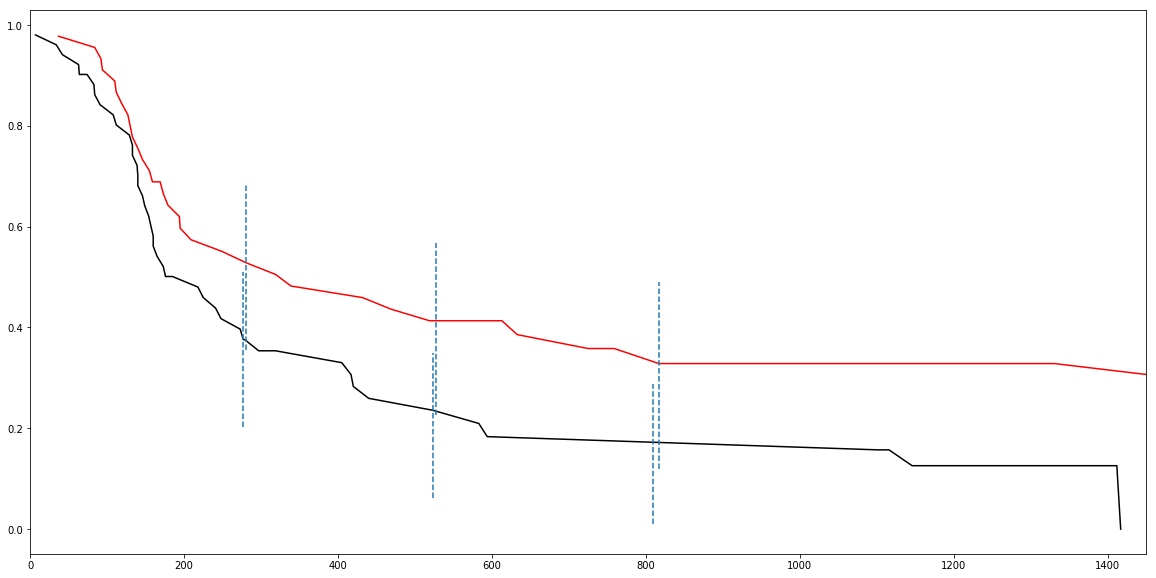

In [9]:
plt.figure(figsize=(20,10))
plt.xlim([0,1450])
plt.plot(df['t'], df['S_hat'], 'k')
plt.plot(dfB['t'], dfB['S_hat'], 'r')
plt.axvline(277, 
            ymin=(df.loc[df['t'] == 277, 'S_hat'] - 2 * df.loc[df['t'] == 277, 'se_Shat']).values[0],
            ymax=(df.loc[df['t'] == 277, 'S_hat'] + 2 * df.loc[df['t'] == 277, 'se_Shat']).values[0], ls='--')
plt.axvline(281, 
            ymin=(dfB.loc[dfB['t'] == 281, 'S_hat'] - 2 * dfB.loc[dfB['t'] == 281, 'se_Shat']).values[0],
            ymax=(dfB.loc[dfB['t'] == 281, 'S_hat'] + 2 * dfB.loc[dfB['t'] == 281, 'se_Shat']).values[0], ls='--')
plt.axvline(523, 
            ymin=(df.loc[df['t'] == 523, 'S_hat'] - 2 * df.loc[df['t'] == 523, 'se_Shat']).values[0],
            ymax=(df.loc[df['t'] == 523, 'S_hat'] + 2 * df.loc[df['t'] == 523, 'se_Shat']).values[0], ls='--')
plt.axvline(528, 
            ymin=(dfB.loc[dfB['t'] == 528, 'S_hat'] - 2 * dfB.loc[dfB['t'] == 528, 'se_Shat']).values[0],
            ymax=(dfB.loc[dfB['t'] == 528, 'S_hat'] + 2 * dfB.loc[dfB['t'] == 528, 'se_Shat']).values[0], ls='--')
plt.axvline(810, 
            ymin=(df.loc[df['t'] == 594, 'S_hat'] - 2 * df.loc[df['t'] == 594, 'se_Shat']).values[0],
            ymax=(df.loc[df['t'] == 594, 'S_hat'] + 2 * df.loc[df['t'] == 594, 'se_Shat']).values[0], ls='--')
plt.axvline(817, 
            ymin=(dfB.loc[dfB['t'] == 817, 'S_hat'] - 2 * dfB.loc[dfB['t'] == 817, 'se_Shat']).values[0],
            ymax=(dfB.loc[dfB['t'] == 817, 'S_hat'] + 2 * dfB.loc[dfB['t'] == 817, 'se_Shat']).values[0], ls='--')

In [10]:
df = df.groupby('month_abs') \
  .agg({'d':'sum', 't':'count', 'S_hat':'min'}) \
  .reset_index()
df['l'] = df['t'] - df['d']
df['month_abs'] = df['month_abs'].map(int)
df['S_hat'] = df['S_hat'].round(3)
df.drop('t',1, inplace=True)

In [11]:
df_all = pd.DataFrame({'month_all':np.linspace(df['month_abs'].min(), df['month_abs'].max(),
                                               df['month_abs'].max() - df['month_abs'].min() + 1)})
df_all['month_all'] = df_all['month_all'].map(int)

In [12]:
df = pd.merge(df_all, df, left_on=['month_all'], right_on=['month_abs'], how='left')
df.drop('month_abs', 1, inplace=True)

In [13]:
df['S_hat'].fillna(method='pad', inplace=True)
df.fillna(0, inplace=True)
df.rename(columns={'d':'y'}, inplace=True)
df['n'] = 52 - (df['y'].expanding(2).sum() + df['l'].expanding(2).sum())
df.iloc[0,-1] = 51
df['h'] = (df['y'] / (df['n'] + df['l'])).round(3)
df['se_Shat'] = df['S_hat'] * np.sqrt((df['y'] / (df['n'] * (df['n'] - df['y']))).cumsum())
df[['month_all', 'n', 'y', 'l', 'h', 'S_hat','se_Shat']]

,month_all,n,y,l,h,S_hat,se_Shat
0,1,51.0,1.0,0.0,0.020,0.980,0.019407
1,2,49.0,2.0,0.0,0.041,0.941,0.033410
2,3,44.0,4.0,1.0,0.089,0.862,0.051239
3,4,41.0,3.0,0.0,0.073,0.802,0.059255
4,5,33.0,8.0,0.0,0.242,0.641,0.078913
5,6,26.0,7.0,0.0,0.269,0.501,0.085795
6,7,25.0,0.0,1.0,0.000,0.501,0.085795
7,8,23.0,2.0,0.0,0.087,0.459,0.083969
8,9,21.0,2.0,0.0,0.095,0.418,0.081995
9,10,17.0,3.0,1.0,0.167,0.354,0.080010


In [14]:
df['Arm'] = 'A'
df.to_csv('life_table_A.csv')

In [15]:
dfB = dfB.groupby('month_abs') \
  .agg({'d':'sum', 't':'count', 'S_hat':'min'}) \
  .reset_index()
dfB['l'] = dfB['t'] - dfB['d']
dfB['month_abs'] = dfB['month_abs'].map(int)
dfB['S_hat'] = dfB['S_hat'].round(3)
dfB.drop('t',1, inplace=True)

In [16]:
df_allB = pd.DataFrame({'month_all':np.linspace(dfB['month_abs'].min(), dfB['month_abs'].max(),
                                               dfB['month_abs'].max() - dfB['month_abs'].min() + 1)})
df_allB['month_all'] = df_allB['month_all'].map(int)

dfB = pd.merge(df_allB, dfB, left_on=['month_all'], right_on=['month_abs'], how='left')
dfB.drop('month_abs', 1, inplace=True)

In [17]:
dfB['S_hat'].fillna(method='pad', inplace=True)
dfB.fillna(0, inplace=True)
dfB.rename(columns={'d':'y'}, inplace=True)
dfB['n'] = 46 - (dfB['y'].expanding(2).sum() + dfB['l'].expanding(2).sum())
dfB.iloc[0,-1] = 45
dfB['h'] = (dfB['y'] / (dfB['n'] + dfB['l'])).round(3)
dfB['se_Shat'] = dfB['S_hat'] * np.sqrt((dfB['y'] / (dfB['n'] * (dfB['n'] - dfB['y']))).cumsum())
dfB[['month_all', 'n', 'y', 'l', 'h', 'S_hat','se_Shat']]

,month_all,n,y,l,h,S_hat,se_Shat
0,2,45.0,1.0,0.0,0.022,0.978,0.021979
1,3,44.0,1.0,0.0,0.023,0.956,0.030735
2,4,39.0,5.0,0.0,0.128,0.844,0.058500
3,5,34.0,5.0,0.0,0.147,0.733,0.072842
4,6,29.0,4.0,1.0,0.133,0.643,0.079775
5,7,26.0,3.0,0.0,0.115,0.574,0.082002
6,8,26.0,0.0,0.0,0.000,0.574,0.082002
7,9,25.0,1.0,0.0,0.040,0.551,0.081867
8,10,24.0,1.0,0.0,0.042,0.528,0.081606
9,11,23.0,1.0,0.0,0.043,0.505,0.081215


In [19]:
dfB['Arm'] = 'B'
dfB.to_csv('life_table_B.csv')